<a href="https://colab.research.google.com/github/dwishashah/Time-Series-Analysis/blob/main/%20Vector_Autoregression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vector Autoregression

Vector AutoRegressive (VAR) is a multivariate forecasting algorithm that is used when two or more time series influence each other.

VAR is a bidirectional model.

In a bidirectional model, variables influence each other.

The VAR (1) model with two time series (Y1 and Y2):

Ŷ1,t = μ1 + ϕ11Y1,t-1 + ϕ12Y1,t-2 + ɛ1,t

Ŷ2,t = μ2 + ϕ21Y2,t-1 + ϕ22Y2,t-2 + ɛ2,t

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv(r'/content/ice_cream_vs_heater.csv', parse_dates= True)

In [ ]:
df.head(50)

,Month,heater,ice cream
0,2004-01,27,13
1,2004-02,18,15
2,2004-03,14,16
3,2004-04,13,19
4,2004-05,13,21
5,2004-06,13,24
6,2004-07,13,27
7,2004-08,14,20
8,2004-09,15,18
9,2004-10,20,15


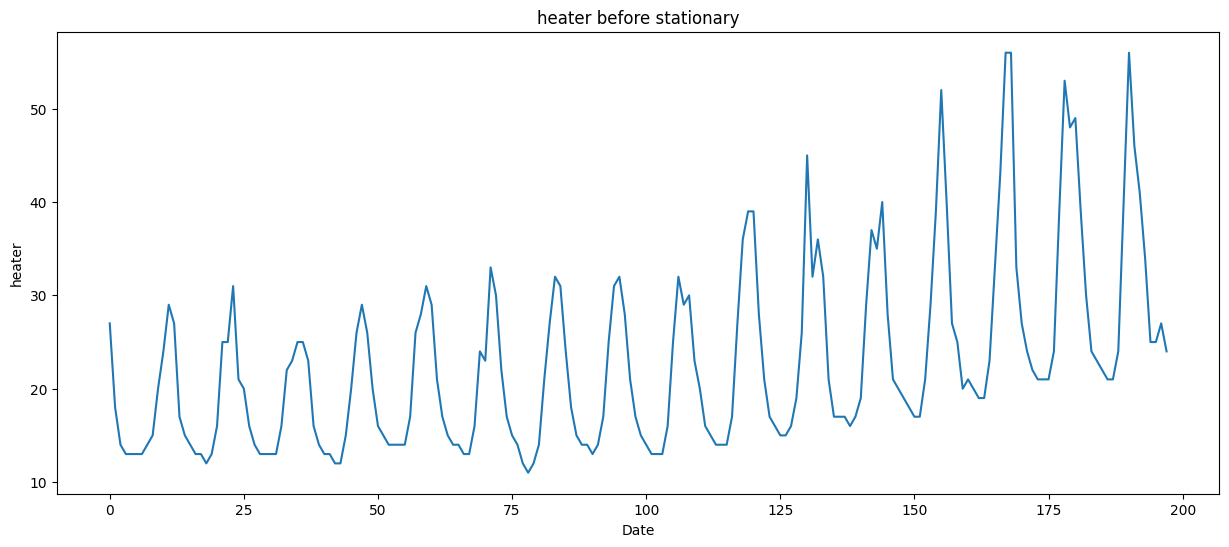

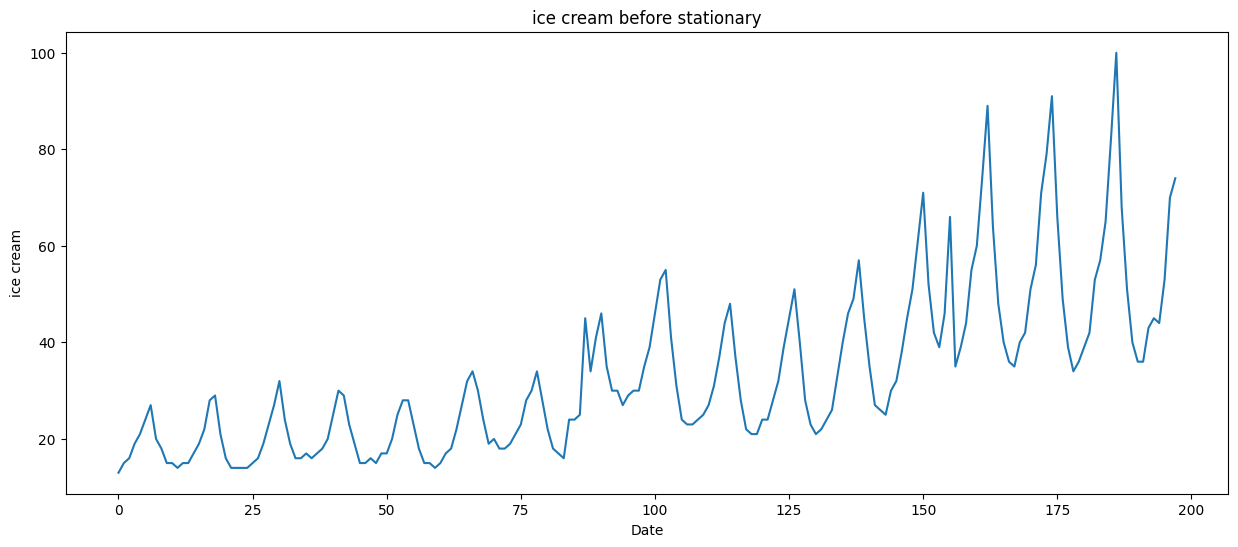

In [ ]:
for c in df[['heater','ice cream']]:
    df[str(c)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(c)
    plt.title(f"{str(c)} before stationary")
    plt.show()

The following loop will plot a histogram and KDE for all the columns before making it stationary:

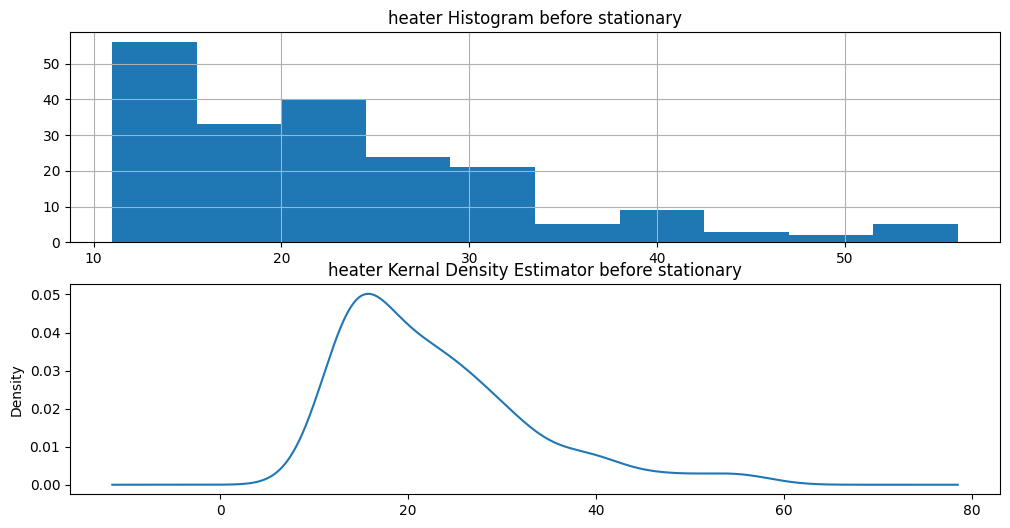

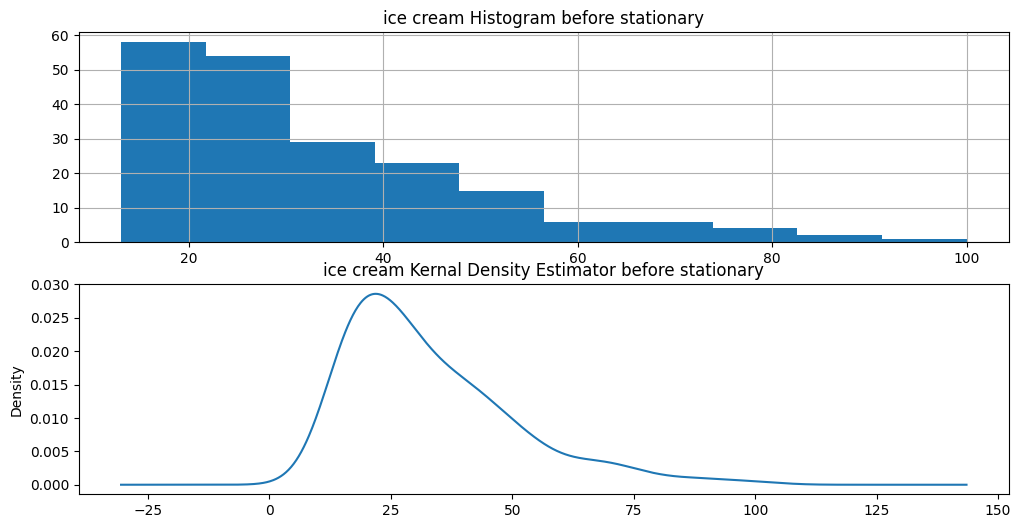

In [ ]:
for c in df[['heater','ice cream']]:
    plt.figure(1, figsize=(12,6))
    plt.subplot(211)
    plt.title(f"{str(c)} Histogram before stationary")
    df[str(c)].hist()
    plt.subplot(212)
    df[str(c)].plot(kind='kde')
    plt.title(f"{str(c)} Kernal Density Estimator before stationary")
    plt.show()

Define a time-series evaluation function, as shown below:

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    #print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    return

Here is the ADF test function to check for stationary data:


In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

Here is how to check whether the variables are stationary:"

In [ ]:
for name, column in df[['heater','ice cream']].iteritems():
    Augmented_Dickey_Fuller_Test_func(df[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: heater
Test Statistic                   0.950111
p-value                          0.993711
No Lags Used                    11.000000
Number of Observations Used    186.000000
Critical Value (1%)             -3.466005
Critical Value (5%)             -2.877208
Critical Value (10%)            -2.575122
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: ice cream
Test Statistic                  -0.303933
p-value                          0.924945
No Lags Used                    13.000000
Number of Observations Used    184.000000
Critical Value (1%)             -3.466398
Critical Value (5%)             -2.877380
Critical Value (10%)            -2.575214
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary




Make a copy of the data, and let’s perform the test train split. The train will have all the data except the last 30 days, and the test will contain only the last 30 days to evaluate against the predictions.

In [ ]:
X = df[['heater','ice cream']]
train, test = X[0:-30], X[-30:]

Make the data stationary by using Pandas differencing, as shown here:

In [ ]:
train_diff = train.diff()
train_diff.dropna(inplace = True)

Check whether the variables are stationary after first differencing, as shown here:

In [ ]:
for name, column in train_diff[['heater','ice cream']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: heater
Test Statistic                  -5.105082
p-value                          0.000014
No Lags Used                    13.000000
Number of Observations Used    153.000000
Critical Value (1%)             -3.473830
Critical Value (5%)             -2.880623
Critical Value (10%)            -2.576945
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: ice cream
Test Statistic                  -3.226194
p-value                          0.018518
No Lags Used                    12.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary




Create the plots after making the data stationary, as shown below:

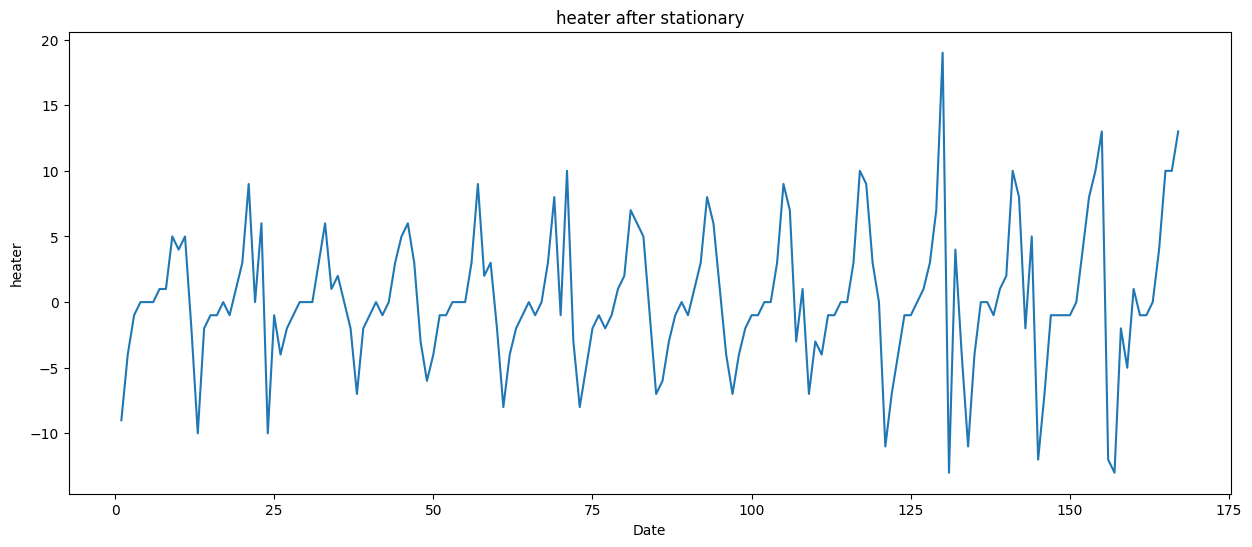

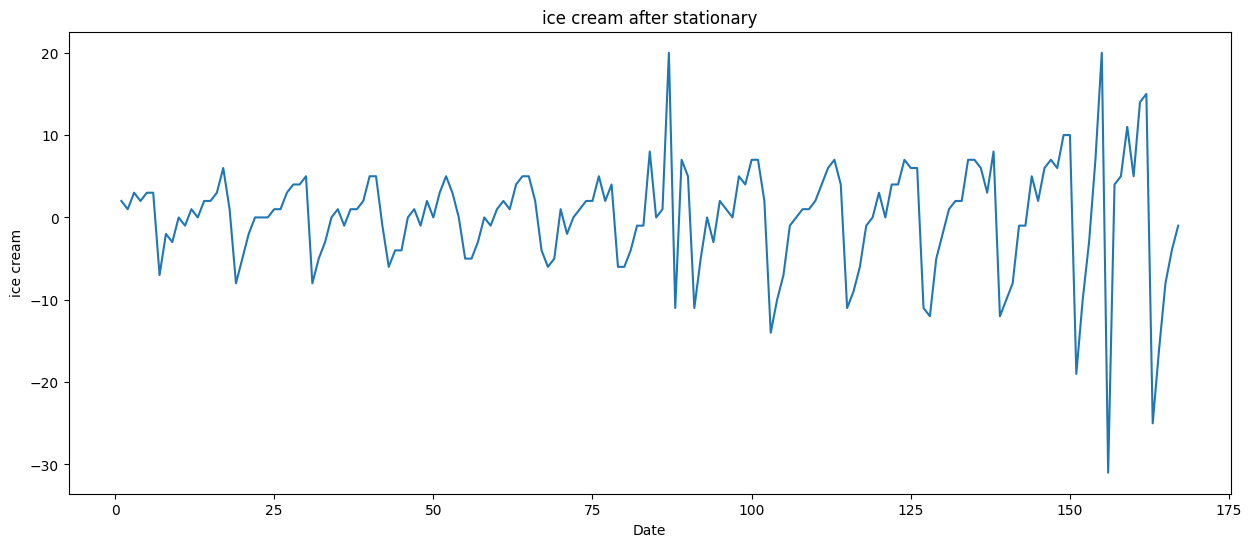

In [ ]:
for c in train_diff[['heater','ice cream']]:
    train_diff[str(c)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(c)
    plt.title(f"{str(c)} after stationary")
    plt.show()

The following loop will plot a histogram and KDE for all the columns after making it stationary

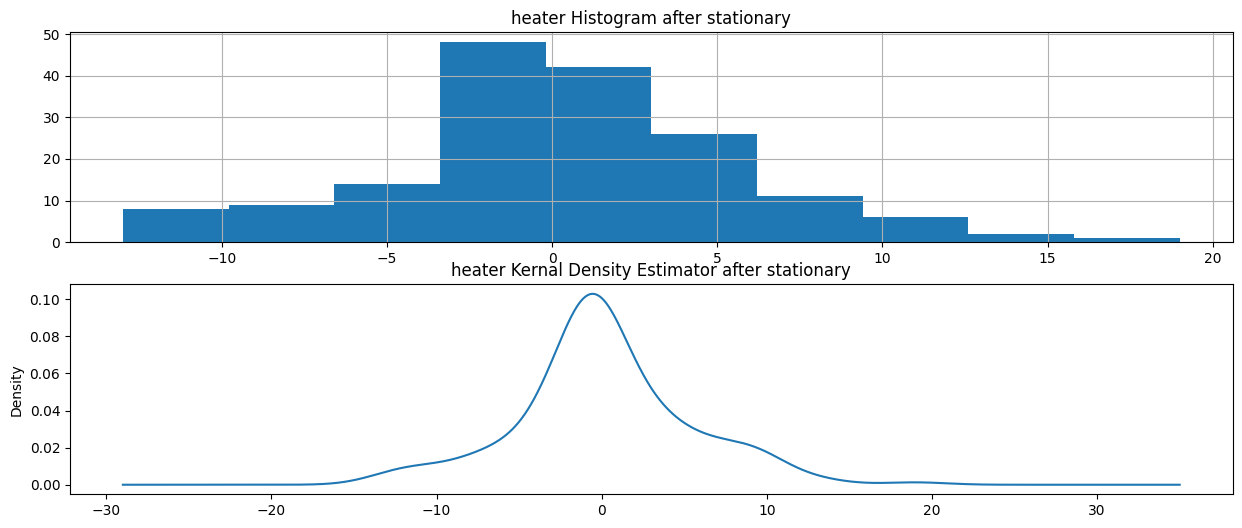

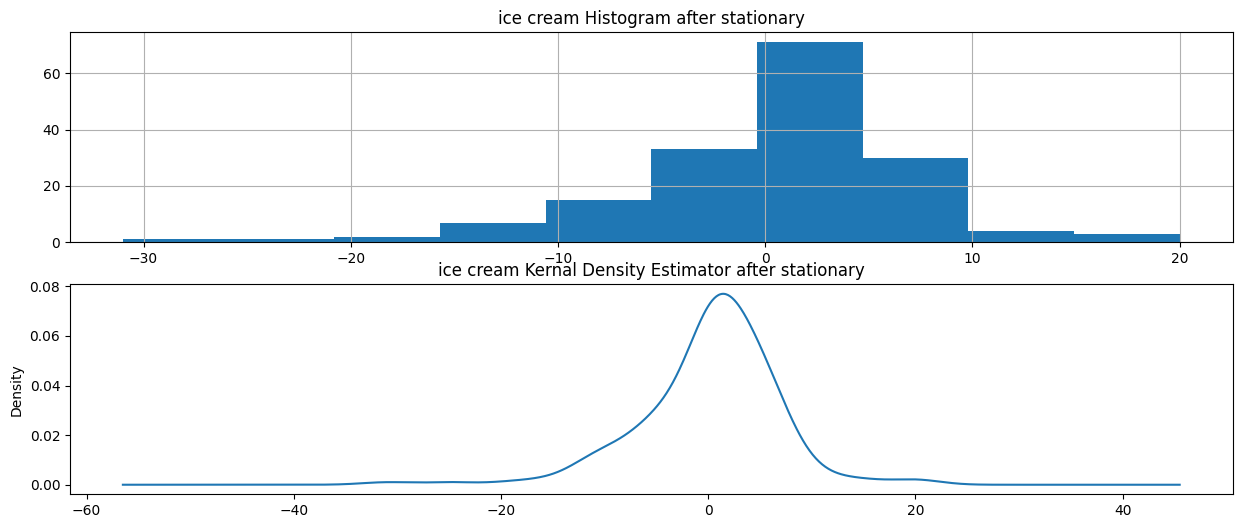

In [ ]:
for c in train_diff[['heater','ice cream']]:
    plt.figure(1, figsize=(15,6))
    plt.subplot(211)
    plt.title(f"{str(c)} Histogram after stationary")
    train_diff[str(c)].hist()
    plt.subplot(212)
    train_diff[str(c)].plot(kind='kde')
    plt.title(f"{str(c)} Kernal Density Estimator after stationary")
    plt.show()

In [ ]:
train_diff.head(10)

,heater,ice cream
1,-9.0,2.0
2,-4.0,1.0
3,-1.0,3.0
4,0.0,2.0
5,0.0,3.0
6,0.0,3.0
7,1.0,-7.0
8,1.0,-2.0
9,5.0,-3.0
10,4.0,0.0


A cointegration test is the co-movement among underlying variables over the long run.

Cointegration analysis aims to uncover causal relations among variables by determining if the stochastic trends in a group of variables are shared by the series. If these trends are shared, either one variable causes the other or they are both driven by a third variable.

Two or more variables are cointegrated if and only if they share common trends.

Correlation is simply a measure of the degree of mutual association between two or more variables.

We can see that the test says that there is the presence of a long-run relationship between features.

coint_johansen():

coint_johansen(endog, det_order, k_ar_diff)

det_order - int

-1 - no deterministic terms

0 - constant term

1 - linear trend

k_ar_diffint - nonnegative

Number of lagged differences in the model.

The second term in the arguments represents the order of null hypothesis. The third term specifies the number of lagged difference terms used when computing the estimator.

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1 # Trace statistics
    cvts = res.cvt[:, d[str(1-0.05)]] #Critical values (90%, 95%, 99%) for trace statistic.
    def adjust(val, length= 6):
        return str(val).ljust(length) #string left justified (ljust)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [ ]:
cointegration_test(train_diff[['heater','ice cream']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
heater >  227.6     > 12.3212   =>   True
ice cream >  73.24     > 4.1296    =>   True


Fit the VAR model for the AR term between 1 to 9 and choose the best AR component, as shown here:

In [ ]:
for i in [1,2,3,4,5,6,7,8,9]:
    model = VAR(train_diff)
    results = model.fit(i)
    print(f'Order : {i}, AIC:  {results.aic}, BIC: { results.bic}')

Order : 1, AIC:  6.80014157598582, BIC: 6.91262306231196
Order : 2, AIC:  6.704832687622487, BIC: 6.8930718072528245
Order : 3, AIC:  6.522822282970299, BIC: 6.787445026808951
Order : 4, AIC:  6.0983540316297065, BIC: 6.4399951580991655
Order : 5, AIC:  5.777051820450966, BIC: 6.1963550264701786
Order : 6, AIC:  5.444994678191652, BIC: 5.942612774400322
Order : 7, AIC:  5.398655213741296, BIC: 5.975250304097639
Order : 8, AIC:  5.251406730862433, BIC: 5.907650396746005
Order : 9, AIC:  5.180967360998225, BIC: 5.917540849954078


To make data stationary, we used Pandas differencing after forecasting the results. We need to inverse the result to the original scale. As we don’t have a Pandas function for this, let’s define a custom function to inverse Pandas differencing.

In [ ]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

Autoregressive AR(4) appears to be providing the least Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC), so let’s fit and forecast.

AIC and BIC are two ways of scoring a model based on its log likelihood and complexity.

In [ ]:
results = model.fit(4)
display(results.summary())
z = results.forecast(y=train_diff[['heater', 'ice cream']].values, steps=30)
df_pred = pd.DataFrame(z, columns=['heater', 'ice cream' ])

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Nov, 2023
Time:                     03:03:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    6.44000
Nobs:                     163.000    HQIC:                   6.23706
Log likelihood:          -941.590    FPE:                    445.225
AIC:                      6.09835    Det(Omega_mle):         399.850
--------------------------------------------------------------------
Results for equation heater
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.300479         0.285633            1.052           0.293
L1.heater            0.039606         0.072233            0.548           0.583
L1.ice cream        -0.248008         0.047581           -5.212

Arrange an index for aligning plots, as shown below:

In [ ]:
df_pred["new_index"] = range(167,197)
df_pred = df_pred.set_index("new_index")

In [ ]:
df_pred

,heater,ice cream
new_index,,
167,-0.715255,-3.134903
168,-3.859941,-3.846154
169,-4.870582,0.023020
170,-4.303161,4.489816
171,-0.282515,8.565086
172,-1.484585,5.020317
173,-1.461292,-0.009346
174,-0.165563,-3.326854
175,1.558638,-3.916893


Let’s inverse the differenced prediction, as shown below:

In [ ]:
res = inverse_diff(df[['heater', 'ice cream' ]],df_pred)

In [ ]:
res

,heater,ice cream,heater_1st_inv_diff,ice cream_1st_inv_diff
new_index,,,,
167,-0.715255,-3.134903,23.284745,70.865097
168,-3.859941,-3.846154,19.424804,67.018943
169,-4.870582,0.023020,14.554221,67.041963
170,-4.303161,4.489816,10.251060,71.531779
171,-0.282515,8.565086,9.968545,80.096864
172,-1.484585,5.020317,8.483961,85.117181
173,-1.461292,-0.009346,7.022669,85.107835
174,-0.165563,-3.326854,6.857106,81.780981
175,1.558638,-3.916893,8.415743,77.864088


Evaluate the results individually, as shown below:

In [ ]:
for i in ['heater','ice cream']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for heater
MSE is : 439.12527380399143
MAE is : 18.625516640906138
RMSE is : 20.955316122740584
MAPE is : 55.72504923106704
R2 is : -2.343593455360341

Evaluation metric for ice cream
MSE is : 783.7526737024581
MAE is : 24.889418800766315
RMSE is : 27.99558311059904
MAPE is : 56.022566543207176
R2 is : -1.5759118827773269



Plot the results, as shown below:

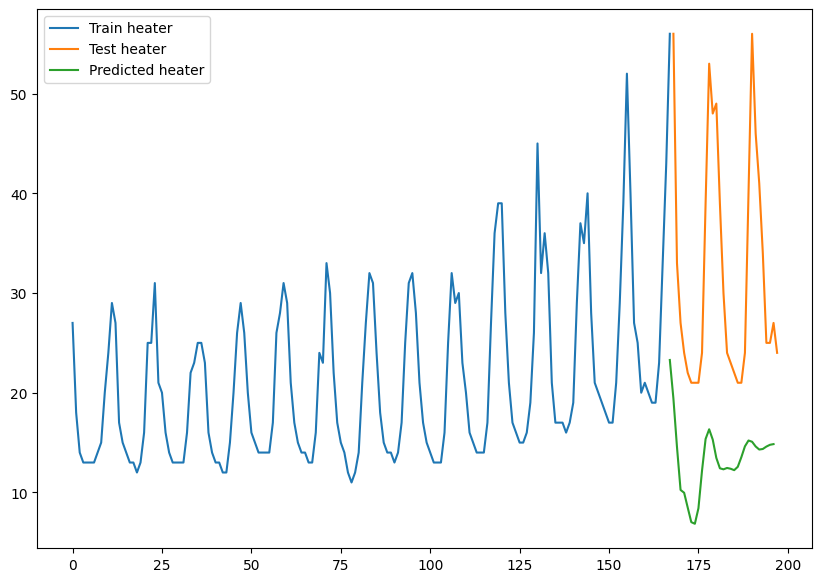

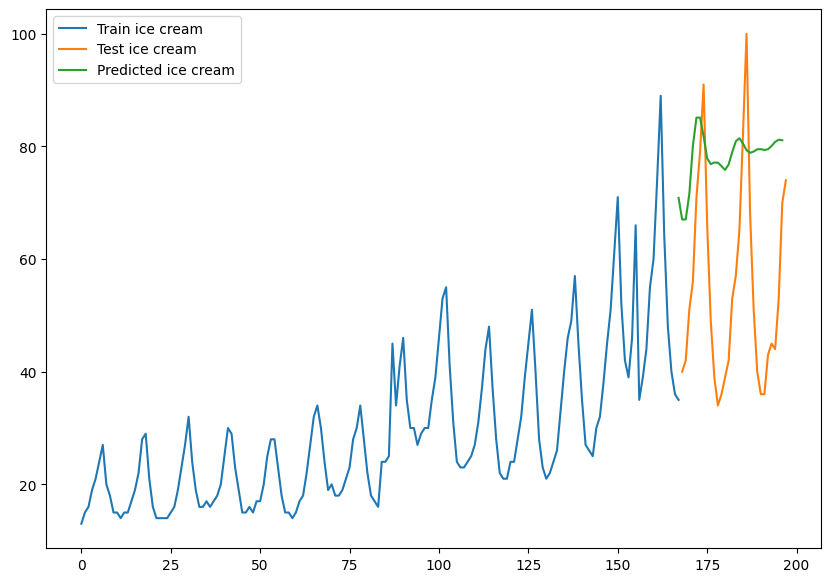

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['heater','ice cream' ]:

    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot( train[str(i)], label='Train '+str(i))
    plt.plot(test[str(i)], label='Test '+str(i))
    plt.plot(res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()